# COMPAS Analysis
What follows are the calculations of the COMPAS Recidivism Risk Scores. These calculations are based on [ProPublica's analysis methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm/).

## Loading the Data
We select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

Following COMPAS ProPublica analysis, we will filter out rows where `days_b_screening_arrest` is over 30 or under -30, leaving us with 6,172 rows.

Following Chouldechova (2017), we will also subset the observations only for `African-American` and `Causasian`. This leaves us with 5,278 rows.`

The data loading and filtering can be found in the `compas_data.py`

In [2]:
!pygmentize compas_data.py

#!/usr/bin/env python
# coding: utf-8

def load_data():
  import pandas as pd
  df = pd.read_csv('data/compas-scores-two-years.csv', index_col=0)
  df = df[(df['days_b_screening_arrest'] <= 30) & (df['days_b_screening_arrest'] >= -30)]
  df = df[(df['race'] == 'African-American') | (df['race'] == 'Caucasian')]
  return df

if __name__ == '__main__':
  load_data()


In [3]:
from compas_data import load_data

df = load_data()
df.shape

(5278, 52)

## Race Cross-tabulations

This is an important cross-tabulation, because the `two_year_recid` is a *dummy* variable indicating wether the defendant recidivated or not in a two year time. 

In [4]:
ct1 = pd.crosstab(df['race'], df['two_year_recid'])
ct1

two_year_recid,0,1
race,,
African-American,1514,1661
Caucasian,1281,822


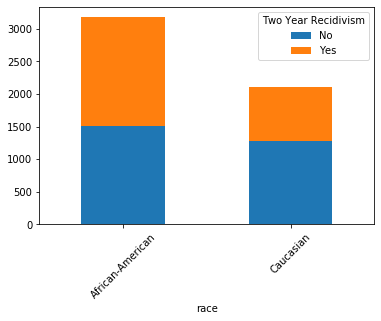

In [5]:
ct1.plot.bar(stacked=True, rot=45)
plt.legend(['No', 'Yes'], title='Two Year Recidivism')
plt.show()

As we can see, we do not have a parity between african-americans and caucasians in recidivism rate

In [6]:
ct2 = pd.crosstab(df['race'], df['score_text'])
ct2

score_text,High,Low,Medium
race,,,
African-American,845,1346,984
Caucasian,223,1407,473


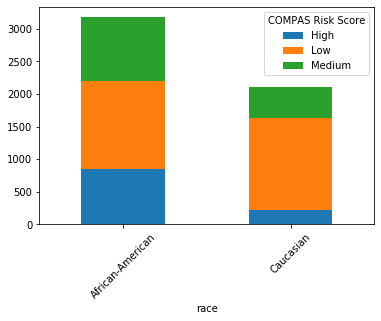

In [7]:
ct2.plot.bar(stacked=True, rot=45)
plt.legend(title='COMPAS Risk Score')
plt.show()

Also african-americans have way more high risk compared to causasians

## ProPublica Data Processing

According to Larson et al. (2016), the ProPublica's Angwin et al. (2016) methodology used only a subset of variables with the following processing:

* Dependent Variable `score_factor` based of `v_score_text`:
    * 0 = `Low`
    * 1 = `Medium + High`

* Independents Variables:
    * `sex_female`: 0 Male, 1 Female
    * `age_less_25`: 0 More Than 25, 1 Less than 25
    * `age_more_45`: 0 Less Than 45, 1 More than 45
    * `race_black`: 0 White, 1 Black
    * `priors_count`
    * `crime_M`: based on `c_charge_degree`: Description of the original criminal charge (0 is F Felony, 1 is M Misdemeanor)

In [8]:
df['score_factor'] = np.where(df['v_score_text'] == 'Low', 0, 1)
df['sex_female'] = np.where(df['sex'] == 'Female', 1, 0)
df['age_less_25'] = np.where(df['age_cat'] == 'Less than 25', 1, 0)
df['age_more_45'] = np.where(df['age_cat'] == 'Greater than 45', 1, 0)
df['race_black'] = np.where(df['race'] == 'African-American', 1, 0)
df['crime_M'] = np.where(df['c_charge_degree'] == 'M', 1, 0)

### ProPublica's Logistic Regression Model

ProPublica used the following logistic regression formula using the `stats` R package function `glm`:

`glm(formula = score_factor ~ gender_factor + age_factor + race_factor + priors_count + crime_factor + two_year_recid, family = "binomial", data = df)`

This formula is to assess how an individual risk is classified (`Low` or `Medium + High` `score_factor`) controlling for real recidivism rate (`two_year_recid`)

## Subsetting the Data

Only selecting ProPublica's variable to the model

In [9]:
df.columns

Index(['name', 'first', 'last', 'compas_screening_date', 'sex', 'dob', 'age',
       'age_cat', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'days_b_screening_arrest',
       'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date',
       'c_arrest_date', 'c_days_from_compas', 'c_charge_degree',
       'c_charge_desc', 'is_recid', 'r_case_number', 'r_charge_degree',
       'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in',
       'r_jail_out', 'violent_recid', 'is_violent_recid', 'vr_case_number',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
       'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid', 'score_factor', 'sex_female',
       'age_less_25', 'age_more_45', 'race_black', 'cri

In [10]:
variables=['two_year_recid', 'sex_female', 'score_factor',
           'age_less_25', 'age_more_45',
           'race_black', 'crime_M', 'priors_count']
target=['score_factor']

In [11]:
X = df[variables]
y = df[target]

In [12]:
X.shape

(5278, 8)

## Splitting Between Train and Test Size

Using a random seed for replicability and also using 0.25 as test size 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=123)

In [14]:
print('Train size: ', X_train.shape)
print('Test size: ', X_test.shape)

Train size:  (3958, 8)
Test size:  (1320, 8)


## Saving `CSV` files

In [15]:
X_train = X_train.to_csv('data/X_train.csv', index=False)
X_test = X_test.to_csv('data/X_test.csv', index=False)
y_train = y_train.to_csv('data/y_train.csv', index=False)
y_test = y_test.to_csv('data/y_test.csv', index=False)

# References

Angwin, J., Larson, J., Mattu, S., & Kirchner, L. (2016). Machine Bias: there’s software used across the country to predict future criminals. And it’s biased against blacks. ProPublica. https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing

Chouldechova, A. (2017). Fair Prediction with Disparate Impact: A Study of Bias in Recidivism Prediction Instruments. Big Data, 5(2), 153–163. https://doi.org/10.1089/big.2016.0047

Larson, J., Mattu, S., Kirchner, L., & Angwin, J. (2016). How we analyzed the COMPAS recidivism algorithm. ProPublica. https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm